## Experimenting K-means reliability

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

link = "https://github.com/lmassaron/datasets/"
link += "releases/download/1.0/penguins.feather"
penguins = pd.read_feather(link)

In [2]:
features = penguins.iloc[:,1:5]
le = LabelEncoder()
labels = le.fit_transform(penguins.species)
target_names = dict(zip(range(3), le.classes_))
print(target_names)

{0: 'Adelie', 1: 'Chinstrap', 2: 'Gentoo'}


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans, KMeans

pca = Pipeline([
    ('scaling', StandardScaler()),
    ('pca', PCA())
])

k_means = KMeans(n_clusters=3, init='k-means++', 
            max_iter=999, n_init=10, random_state=101)


mb_k_means = MiniBatchKMeans(n_clusters=3, init='k-means++', 
    max_iter=999, batch_size=30, n_init=10, random_state=101)

In [4]:
pca_features = pca.fit_transform(features)
print('Explained variance:')
print(pca.named_steps['pca'].explained_variance_)

k_means.fit(pca_features)
mb_k_means.fit(pca_features)

Explained variance:
[2.75362487 0.7804609  0.36975289 0.10820954]


MiniBatchKMeans(batch_size=30, compute_labels=True, init='k-means++',
                init_size=None, max_iter=999, max_no_improvement=10,
                n_clusters=3, n_init=10, random_state=101,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

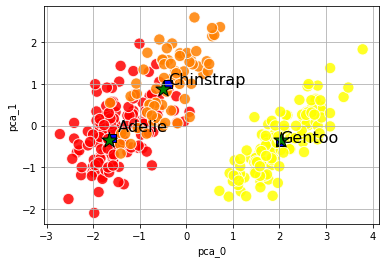

In [5]:
import matplotlib.pyplot as plt

plt.scatter(pca_features[:,0], pca_features[:,1], s=2**7, c=labels, 
            edgecolors='white', alpha=0.85, cmap='autumn')

plt.xlabel('pca_0') 
plt.ylabel('pca_1')
plt.grid()

km_centers = k_means.cluster_centers_
mbkm_centers = mb_k_means.cluster_centers_

plt.scatter(km_centers[:,0], km_centers[:,1],
            s=2**6, marker='s', c='blue', edgecolors='black') 
plt.scatter(mbkm_centers[:,0], mbkm_centers[:,1], 
            s=2**8, marker='*', c='green', edgecolors='black')

for class_no in range(0,3): 
    plt.annotate(target_names[class_no], 
                 (pca_features[labels==class_no, 0].mean(), 
                  pca_features[labels==class_no, 1].mean()),
                 fontsize=16)
plt.show()

## Experimenting how centroids converge

In [6]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)

for iteration in range(1, 10):
    k_means = KMeans(n_clusters=3, init='random', 
        max_iter=iteration, n_init=1, random_state=0)
    k_means.fit(pca_features)
    print("Iteration: %i - 2nd centroid: %s" % 
           (iteration, k_means.cluster_centers_[1]))

Iteration: 1 - 2nd centroid: [-0.802  0.586  0.243 -0.033]
Iteration: 2 - 2nd centroid: [-0.513  0.899  0.254 -0.03 ]
Iteration: 3 - 2nd centroid: [-0.442  0.98   0.297 -0.041]
Iteration: 4 - 2nd centroid: [-0.408  0.992  0.351 -0.036]
Iteration: 5 - 2nd centroid: [-0.398  1.004  0.376 -0.035]
Iteration: 6 - 2nd centroid: [-0.394  1.013  0.384 -0.03 ]
Iteration: 7 - 2nd centroid: [-0.394  1.013  0.384 -0.03 ]
Iteration: 8 - 2nd centroid: [-0.394  1.013  0.384 -0.03 ]
Iteration: 9 - 2nd centroid: [-0.394  1.013  0.384 -0.03 ]


In [7]:
pca = Pipeline([('scaling', StandardScaler()),
                ('pca', PCA())])

k_means = KMeans(n_clusters=3, init='k-means++', 
            max_iter=999, n_init=10, random_state=101)

pca_features = pca.fit_transform(features)

In [8]:
k_means.fit(pca_features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=999,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=101, tol=0.0001, verbose=0)

In [9]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=labels, y_pred=k_means.labels_)
cm_str = str(cm).split('\n')
for row in range(3):
    print(f"{target_names[row]:15} {cm_str[row]}")

Adelie          [[  0  22 124]
Chinstrap        [  0  63   5]
Gentoo           [119   0   0]]


In [10]:
from sklearn.metrics import calinski_harabasz_score
ch_scores = list()
max_clus = 20
for clus_no in range(2, max_clus+1):
    k_means = KMeans(n_clusters=clus_no, 
                     init='k-means++', max_iter=999, 
                     n_init=10, random_state=101)
    k_means.fit(pca_features)
    ch = calinski_harabasz_score(pca_features, 
                                 k_means.labels_)
    ch_scores.append(ch)

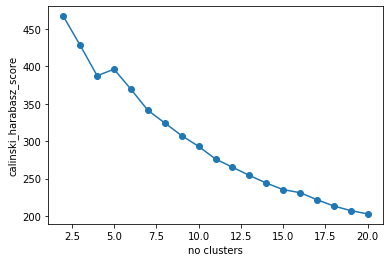

In [11]:
plt.plot(range(2, max_clus+1), ch_scores, 'o-')
plt.xlabel('no clusters') 
plt.ylabel('calinski_harabasz_score')
plt.show()

In [20]:
k_means = KMeans(n_clusters=5, 
                     init='k-means++', max_iter=999, 
                     n_init=10, random_state=101)
k_means.fit(pca_features)

cm = confusion_matrix(y_true=labels, y_pred=k_means.labels_)
for row in range(3):
    print(f"{target_names[row]:10} {cm[row,:]}")

Adelie     [ 0 60 84  2  0]
Chinstrap  [ 0  0  5 63  0]
Gentoo     [57  0  0  0 62]


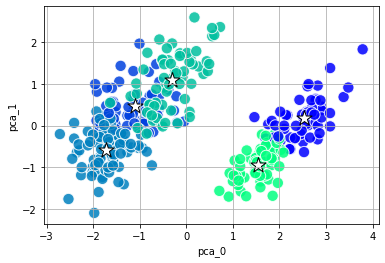

In [13]:
plt.scatter(pca_features[:,0], pca_features[:,1], s=2**7, c=k_means.labels_, 
            edgecolors='white', alpha=0.85, cmap='winter')

km_centers = k_means.cluster_centers_
plt.scatter(km_centers[:,0], km_centers[:,1], 
            s=2**8, marker='*', c='white', edgecolors='black')

plt.xlabel('pca_0') 
plt.ylabel('pca_1')
plt.grid()
plt.show()

## Experimenting with a flexible algorithm

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

knn = KNeighborsClassifier(metric='euclidean')
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
param_grid = {"n_neighbors" : range(1, 16)}

experiment = GridSearchCV(knn, param_grid=param_grid, cv=kfold)

In [15]:
experiment.fit(features, labels)
print(f"best params: {experiment.best_params_}")
print(f"best cv accuracy: {experiment.best_score_:0.3}")

best params: {'n_neighbors': 1}
best cv accuracy: 0.859


In [16]:
experiment.fit(pca_features, labels)
print(f"best params: {experiment.best_params_}")
print(f"best cv accuracy: {experiment.best_score_:0.3}")

best params: {'n_neighbors': 3}
best cv accuracy: 0.991


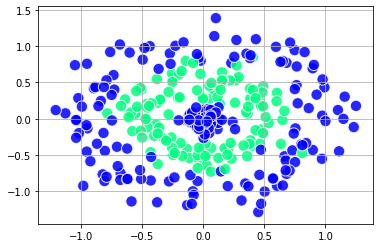

In [17]:
from sklearn.datasets import make_circles, make_blobs

strange_data = make_circles(n_samples=500, shuffle=True, 
                            noise=0.15, random_state=101, factor=0.5)
center = make_blobs(n_samples=100, n_features=2, centers=1, 
                    cluster_std=0.1, center_box=(0, 0))
first_half = np.row_stack((strange_data[0][:250,:],center[0][:50,:]))
first_labels = np.append(strange_data[1][:250],np.array([0]*50))
second_half = np.row_stack((strange_data[0][250:,:],center[0][50:,:]))
second_labels = np.append(strange_data[1][250:],np.array([0]*50))

plt.scatter(first_half[:,0], first_half[:,1], s=2**7, 
            c=first_labels, edgecolors='white', 
            alpha=0.85, cmap='winter')
plt.grid()
plt.show()

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

kNN = KNeighborsClassifier(n_neighbors=3, weights='uniform',
                        algorithm='auto', metric='euclidean')

kNN.fit(first_half,first_labels)
acc = accuracy_score(y_true=second_labels, 
                     y_pred=kNN.predict(second_half))
print(f"Learning accuracy score: {acc:0.3}")

Learning accuracy score: 0.94
